# 8.1 序列模型


- 自回归模型：下一个数据出现和之前数据有关
- 马尔科夫假设：下一个数据出现和之前n个数据相关
- 潜变量假设：把前几个数据集成一个潜变量，预测下一个数据时仅仅用这个潜变量即可

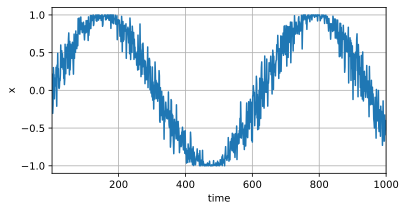

In [5]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time + torch.normal(0, 0.2, (T,)))
d2l.plot(time, [x],'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [9]:
tau = 4 
features = torch.zeros(T-tau, tau)
for i in range(tau):
    features[:, i] = x[i:i+T-tau]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                            batch_size, is_train=True)

In [12]:
def init_weight(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weight)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

In [13]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

C:\Users\59901\AppData\Local\Temp\ipykernel_14408\3087138600.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


epoch 1, loss: 0.048985
epoch 2, loss: 0.029311
epoch 3, loss: 0.027165
epoch 4, loss: 0.025811
epoch 5, loss: 0.024584


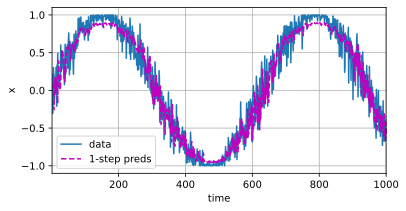

In [14]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
         'x', legend=['data', '1-step preds'], xlim=[1, 1000],
         figsize=(6, 3))

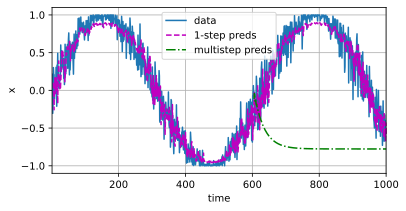

In [15]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train+tau] = x[: n_train+tau]

for i in range(n_train+tau,T):
    multistep_preds[i] = net(multistep_preds[i-tau:i].reshape(1,-1))
    
d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))

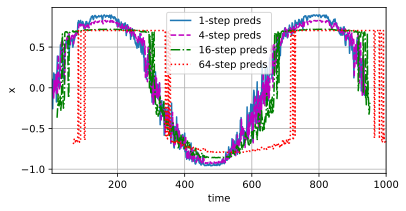

In [21]:
max_steps = 64

features = torch.zeros(T - tau - max_steps + 1, tau + max_steps)

for i in range(tau):
    features[:, i] = x[i : T - tau - max_steps + 1 + i] 

for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i-tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
         legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
         figsize=(6, 3))

# 8.2 文本预处理

主要两个部分，分词和词转为id

In [4]:
import collections
import re
from d2l import torch as d2l

#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


In [5]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


In [6]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
       
        self._token_freq = sorted(counter.items(), key=lambda x:x[0], reverse=True)
        
        self.id_to_word = ['unk'] + reserved_tokens
        self.token_to_idx = {token:idx for idx, token in enumerate(self.id_to_word)}

        for token, freq in self._token_freq:
            if freq < min_freq:
                break
            else:
                self.id_to_word.append(token)
                self.token_to_idx[token] = len(self.id_to_word) - 1

    def __len__(self):
        return len(self.id_to_word)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
        
    @property
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
    
def count_corpus(tokens):
    if len(tokens) == 0 or isinstance(tokens[0], list):
        vocab = [token for line in lines for token in line]
    return collections.Counter(vocab)


In [7]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('unk', 0), ('z', 1), ('y', 2), ('x', 3), ('w', 4), ('v', 5), ('u', 6), ('t', 7), ('s', 8), ('r', 9)]


In [8]:
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [None, None, None, None, 19, 20, None]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [None, None, None, None, None, None, None, None, None, None, None]


In [9]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

# 8.3 语言模型和数据集

### 8.3.3 自然语言统计

In [18]:
import torch
import random
from d2l import torch as d2l

tokens = d2l.tokenize(d2l.read_time_machine())

corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

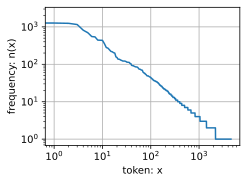

In [19]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
         xscale='log', yscale='log')

In [25]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [26]:
trigram_tokens = [pair for pair in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

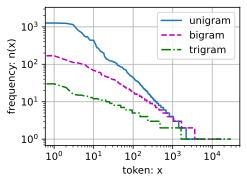

In [27]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
         ylabel='frequency: n(x)', xscale='log', yscale='log',
         legend=['unigram', 'bigram', 'trigram'])

### 8.3.4 长序列读取

In [9]:
import torch
import random
from d2l import torch as d2l
# 随机采样
def seq_data_iter_random(corpus, batch_size, num_steps): 
    corpus = corpus[random.randint(0, num_steps - 1):]
    num_seq = (len(corpus)-1) // num_steps
    initial_indices = list(range(0, num_seq * num_steps, num_steps))
    random.shuffle(initial_indices)
    
    def data(pos):
        return corpus[pos: pos + num_steps]
    
    num_batches = num_seq // batch_size
    for i in range(0, num_batches * batch_size, batch_size):
        initial_indices_per_batch = initial_indices[i: i+batch_size]
        X  = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)
    

In [10]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[21, 22, 23, 24, 25],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[22, 23, 24, 25, 26],
        [ 7,  8,  9, 10, 11]])
X:  tensor([[26, 27, 28, 29, 30],
        [ 1,  2,  3,  4,  5]]) 
Y: tensor([[27, 28, 29, 30, 31],
        [ 2,  3,  4,  5,  6]])
X:  tensor([[16, 17, 18, 19, 20],
        [11, 12, 13, 14, 15]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [12, 13, 14, 15, 16]])


In [11]:
# 顺序分区
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [12]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 1,  2,  3,  4,  5],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 6,  7,  8,  9, 10],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]])
X:  tensor([[11, 12, 13, 14, 15],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]])


In [13]:
class SeqDataLoader:  #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [14]:
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 8.4 循环神经网络

使用n-gram方法，在每个时间t需要考虑前n个，但是继续往前的词纳入考虑，词表增加就是Vn指数级别。所以不如直接使用隐变量模型一次存储前面所有词的信息。


- 对隐状态使用循环计算的神经网络称为循环神经网络（RNN）
- 循环神经网络的隐状态可以捕获直到当前时间步序列的历史信息
- 循环神经网络模型的参数数量不会随着时间步的增加而增加，也就是说隐变量是逐步更新的，不是每个时间步有一个
- 使用困惑度来评价语言模型的质量，最好是1，最差是0，也就是预测下一个词正确的概率

# 8.4 从零开始循环神经网络

In [51]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [5]:
F.one_hot(torch.tensor([0, 2]), num_classes=len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [52]:
X = torch.arange(10).reshape(2, 5)
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

In [53]:
def get_params(vocab_size, num_hidden, device):
    num_input = num_output = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) *0.01
    
    W_xh = normal((num_input, num_hidden))
    W_hh = normal((num_hidden, num_hidden))
    b_hh = torch.zeros(num_hidden, device=device)

    W_hq = normal((num_hidden, num_output))
    b_hq = torch.zeros(num_output, device=device)

    params = [W_xh, W_hh, b_hh, W_hq, b_hq]

    for param in params:
        param.requires_grad_(True)
        
    return params


In [54]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(input, state, params):
    W_xh, W_hh, b_hh, W_hq, b_hq = params
    H, = state

    outputs = []
    for X in input:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_hh)
        output = torch.mm(H, W_hq) + b_hq
        outputs.append(output)
    
    return torch.cat(outputs, dim=0), (H, )


In [55]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)   
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [56]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [57]:
def predict_ch8(prefix, num_preds, net, vocab, device):  
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]

    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape(1,1)

    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])

    for i in range(num_preds):
        pred, state = net(get_input(), state)
        outputs.append(int(pred.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [58]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller svfjowvfjo'

In [69]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [param for param in net.parameters() if params.requires_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum((torch.sum(p.grad) for p in params)))
    
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm


In [61]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [62]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))


困惑度 1.0, 56777.1 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


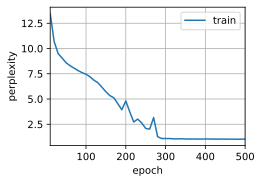

In [70]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

# 8.5 简单实现RNN

In [71]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [72]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

In [ ]:
num_hidden = 256
rnn_layer = nn.RNN(len(vocab), num_hidden, )

In [75]:
state = torch.zeros(1, batch_size, num_hiddens)
state.shape

torch.Size([1, 32, 256])

In [76]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

In [86]:
class RNNModel(nn.Module):
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size

        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.line = nn.Linear(1 * self.num_hiddens, self.vocab_size)
        else:
            self.num_directions = 2
            self.line = nn.Linear(2 * self.num_hiddens, self.vocab_size)
    
    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        output = self.line(Y.reshape(-1, Y.shape[-1]))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # nn.GRU以张量作为隐状态
            return  torch.zeros((self.num_directions * self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                device=device)
        else:
            # nn.LSTM以元组作为隐状态
            return (torch.zeros((
                self.num_directions * self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.num_directions * self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))


In [87]:
device = d2l.try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
d2l.predict_ch8('time traveller', 10, net, vocab, device)

'time travellerp<unk>xjubbbbb'

perplexity 1.3, 245770.2 tokens/sec on cuda:0
time traveller proceeded anyreal body must have extension in fou
traveller sowesthen a knotsong ale gowe facs ded and d inde


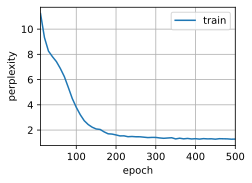

In [88]:
num_epochs, lr = 500, 1
d2l.train_ch8(net, train_iter, vocab, lr, num_epochs, device)

# 8.7. 通过时间反向传播

通过时间反向传播指的是RNN特有的一种反向传播方式。

由于RNN是通过一个MLP来训练所有时间步的信息，所以这个MLP的权重和每一步的隐变量以及输出有关，所以反向传播时候关于权重的计算是连环相乘，呈现迭代的方式。